# <center> Wavefront set inpainting </center>

In this notebook we are implementing a Wavefront set inpainting algorithm based on a hallucination network

In [2]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# Import the needed modules
from data.data_factory import generate_data_WFinpaint, DataGenerator_WFinpaint,random_phantom_generation_lowd
from ellipse.ellipseWF_factory import plot_WF, WFupdate

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/WF_inpaint/data/data_factory.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in lau

/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/WF_inpaint/realphantom/realphantomWF_factory.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", 

## Data generator

In [4]:
batch_size = 1
size = 256
nClasses = 180
lowd = 40

In [5]:
y_arr, x_true_arr = generate_data_WFinpaint(batch_size, size, nClasses, lowd)

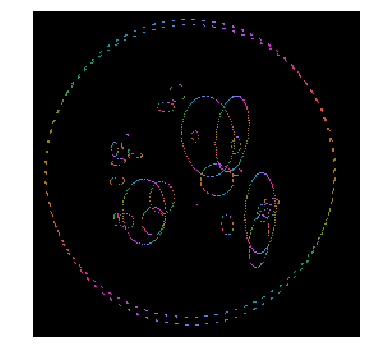

In [6]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(y_arr[0,:,:,0])

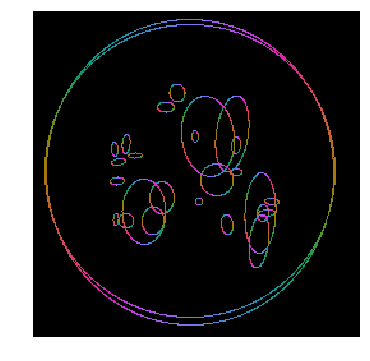

In [7]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(x_true_arr[0,:,:,0])

## Load the model

In [8]:
# Tensorflow and seed
seed_value = 0
import random
random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value)

# Importing relevant keras modules
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from shared.shared import create_increasing_dir
import pickle

In [9]:
# Import model and custom losses
from models.unet import UNet
from models.losses import CUSTOM_OBJECTS

In [10]:
# Parameters for the training
learning_rate = 1e-3
loss = 'mae'
batch_size = 1
epoches = 10000

In [11]:
pretrained = 1
path_to_model_dir = './models/unets_WFinpaint/training_2'

In [12]:
# Data generator
size = 256
nClasses = 180
lowd = 40
train_gen = DataGenerator_WFinpaint(batch_size, size, nClasses, lowd)
val_gen = DataGenerator_WFinpaint(batch_size, size, nClasses, lowd)

In [13]:
if pretrained==0:
    # Create a fresh model
    print("Create a fresh model")
    unet = UNet()
    model = unet.create_model( img_shape = (size, size, 1) , loss = loss, learning_rate = learning_rate)
    path_to_training = create_increasing_dir('./models/unets_WFinpaint', 'training')
    print("Save training in {}".format(path_to_training))
    path_to_model_dir = path_to_training
    
else: 
    print("Use trained model as initialization:")
    print(path_to_model_dir+"/weights.hdf5")
    model = load_model(path_to_model_dir+"/weights.hdf5",
                       custom_objects=CUSTOM_OBJECTS)
    path_to_training = path_to_model_dir

Use trained model as initialization:
./models/unets_WFinpaint/training_2/weights.hdf5
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [14]:
batch_size = 1

In [15]:
phantom, WFimage, WFimage_lowd = random_phantom_generation_lowd(size, nClasses, lowd)

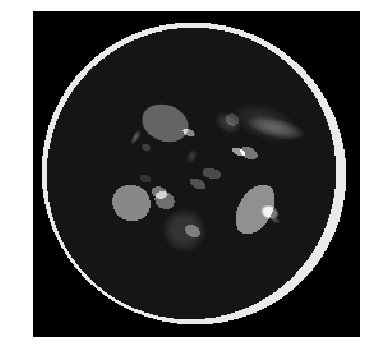

In [19]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(phantom, cmap="gray")
plt.savefig('results/ellipsesphantom.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

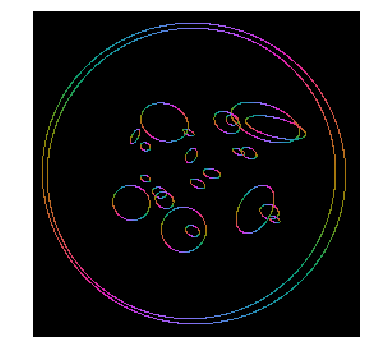

In [18]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(WFimage)
plt.savefig('results/ellipsesphantom-WFset_gt.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

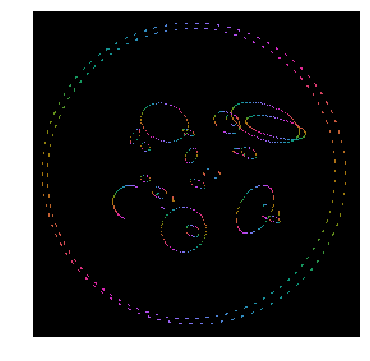

In [17]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(WFimage_lowd)
plt.savefig('results/ellipsesphantom-WFsetlowd_gt.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [20]:
Y_val = WFimage_lowd[np.newaxis, :,:, np.newaxis]
X_true_val = WFimage[np.newaxis, :,:, np.newaxis]

In [21]:
X_predict_val = model.predict(Y_val);

In [22]:
X_predict_val[0,:,:,0][X_predict_val[0,:,:,0] == X_predict_val[0,:,:,0][0,0]] = 0

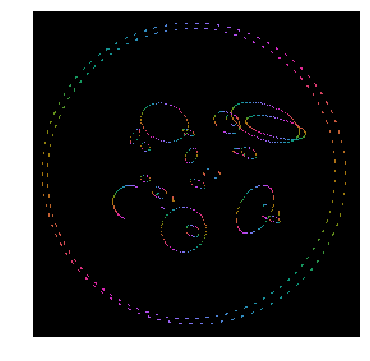

In [23]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(Y_val[0,:,:,0])

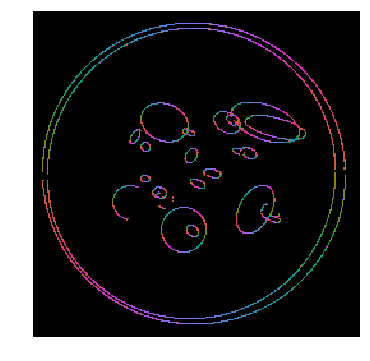

In [24]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(X_predict_val[0,:,:,0])
plt.savefig('results/ellipsesphantom-WFset_predict.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

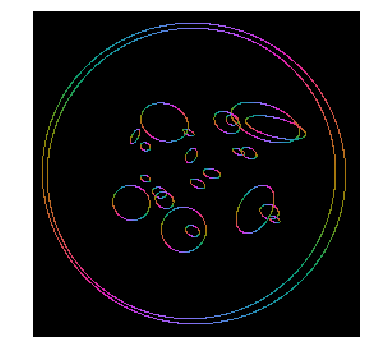

In [25]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(X_true_val[0,:,:,0])

### Shepp-Logan phantom

In [26]:
from coshrem.shearletsystem import EdgeSystem
import coshrem.util
import cmocean

In [27]:
# Perform edge and edge-orientation measurement
def CoShREM(image, min_contrast):
    image_gray = image[:,:,0] 
    sys = EdgeSystem(*image_gray.shape)
    edges, orientations_unmasked = sys.detect(image_gray, min_contrast)
    orientations = np.ma.masked_where(orientations_unmasked == -1, orientations_unmasked)
    cmap = cmocean.cm.phase
    cmap.set_bad(color='black')
    return edges,orientations_unmasked, orientations, cmap

In [28]:
def shepp_logan_WFlowd(size, nClasses, lowd):
    space = odl.uniform_discr([-128, -128], [128, 128], [size, size],
                          dtype='float32')
    geometry = odl.tomo.parallel_beam_geometry(space, num_angles=lowd)
    operator = odl.tomo.RayTransform(space, geometry)
    phantom_shepp_logan = np.array(odl.phantom.shepp_logan(space, True))
    image_shepp_logan =  np.uint8([phantom_shepp_logan*255, phantom_shepp_logan*255, 
                                   phantom_shepp_logan*255]).transpose(1,2,0)
    min_contrast = 5
    (edges_shepp_logan, orientations_shepp_logan_unmasked, 
     WFimage, cmap_shepp_logan) = CoShREM(image_shepp_logan, min_contrast)
    WFset = orientations_shepp_logan_unmasked
    WFpoints = np.concatenate([np.where(WFset!=0)[1][:,np.newaxis],
                       np.where(WFset!=0)[0][:,np.newaxis]], axis = 1)
    WFclasses = [np.array([int(round(WFset[WFpoints[i,1],WFpoints[i,0]]))]) 
                  for i in range(WFpoints.shape[0])]
    # Compute low dose WF image
    angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
    # Extracting the wavefront set orientations in the low dose
    angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
    angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
    # Generating the new WFpoints and classes
    WFpoints_gt_lowd = WFpoints[angles_gt_lowd]
    WFclasses_gt_lowd = list(np.array(WFclasses)[angles_gt_lowd])
    # Generating the low dose WFimage
    WFimage_lowd = np.zeros([size,size])
    WFimage_lowd = WFupdate(WFpoints_gt_lowd, WFclasses_gt_lowd, WFimage_lowd)
    return phantom_shepp_logan, WFimage, WFimage_lowd

In [29]:
phantom_shepp_logan, WFimage, WFimage_lowd = shepp_logan_WFlowd(size, nClasses, lowd);

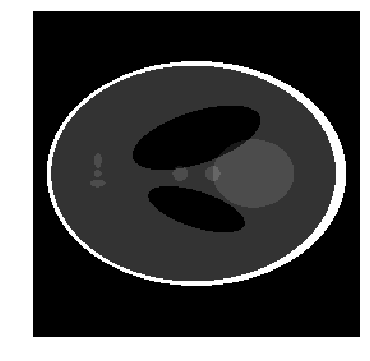

In [30]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(phantom_shepp_logan, cmap="gray")

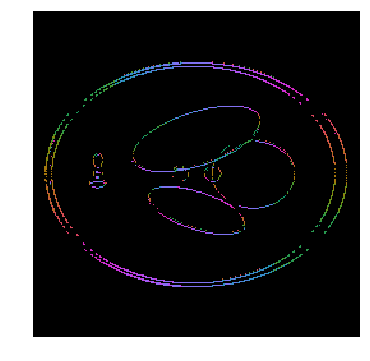

In [31]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

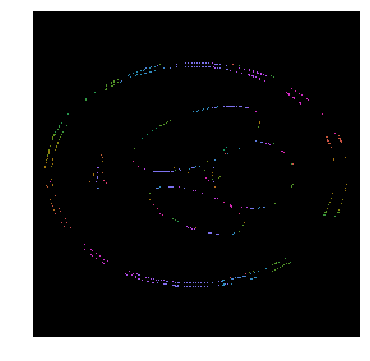

In [32]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)

In [33]:
Y_val = WFimage_lowd[np.newaxis, :,:, np.newaxis]
X_true_val = WFimage[np.newaxis, :,:, np.newaxis]

In [34]:
X_predict_val = model.predict(Y_val);

In [35]:
X_predict_val[0,:,:,0][X_predict_val[0,:,:,0] == X_predict_val[0,:,:,0][0,0]] = 0

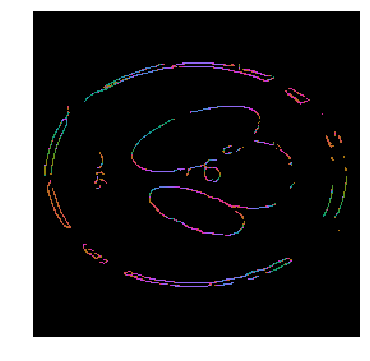

In [37]:
plt.figure(figsize=(6,6))
plt.axis('off')
plot_WF(X_predict_val[0,:,:,0])
plt.savefig('results/shepp-logan-phantom-WFset_predict-ep.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)